In [1]:
# import packages
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
import copy
from datetime import datetime, date, timedelta
from scipy import stats
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib notebook

# Prepare Data

In [2]:
# read in data
og_data = pd.read_csv('trauma_care sites.csv')
outcomes = pd.read_csv('trauma_outcomes.csv')
demo = pd.read_csv('trauma_demo.csv')

In [3]:
print(outcomes.shape)
outcomes.head()

(13723, 13)


,PERSON_ID,ED_HOSP_ARRIVAL_DATE,ED_HOSP_ARRIVAL_TIME,ED_DISCHARGE_DATE,ED_DISCHARGE_TIME,HOSPITAL_DISCHARGE_DATE,HOSPITAL_DISCHARGE_TIME,LOCAL_ISS,ICD_10_PRIMARY_EXTERNAL_CAUSE_CODE,TRANSPORT_MODE,ICD_10_HOSPITAL_PROCEDURES,ICD_10_INJURY_DIAGNOSES,AIS_SEVERITY
0,8966376,1/1/2017,11:14,1/1/2017,unk,1/5/2017,11:38,30.0,V47.6XXA,1,"5A1935Z, 0BH17EZ, BW25YZZ, BW28ZZZ, BR20ZZZ, B...","S02.0XXA, S02.113A, S02.19XA, S02.0XXA, S06.5X...","2, 3, 3, 4, 3, 3, 3, 5, 1, 1, 2, 2"
1,7508586,1/1/2017,0:18,1/1/2017,4:25,1/4/2017,8:25,14.0,V47.02XA,1,"BW29ZZZ, BW251ZZ, 0QSG06Z ...","S22.42XA, S27.2XXA, S27.321A, S32.119A, S82.45...","3, 3, 2, 2, 2, 2, 1, 2"
2,12522608,1/1/2017,6:48,1/1/2017,7:00,1/6/2017,14:46,17.0,Y04.0XXA,1,"BW29ZZZ, BN25ZZZ, BW251ZZ, B3251ZZ, B3281ZZ, B...","S06.6X0A, S06.5X0A, S01.311A, S00.03XA, S02.0X...","2, 4, 1, 1, 2, 3"
3,10201634,1/1/2017,23:09,1/1/2017,23:22,1/12/2017,11:22,9.0,X93.XXXA,1,"BW28ZZZ, BW25YZZ, BR20ZZZ, 0DTH0ZZ, 0DCV0ZZ, 0...","S32.421A, S30.0XXA, S36.438A, S36.438A, S61.42...","2, 1, 2, 2, 1, 1"
4,10673610,1/1/2017,10:20,1/1/2017,unk,1/2/2017,unk,14.0,V47.02XA,1,"BW41ZZZ, BW28ZZZ, BR20ZZZ, BN25ZZZ, BW25YZZ, 0...","S06.319A, S02.31XA, S02.2XXA, S05.8X1A, S01.11...","3, 2, 2, 1, 1, 1, 1, 1"


In [4]:
print(og_data.shape)
og_data.head()

(250250, 4)


,PERSON_ID,CARE_SITE_DATETIME,CARE_SITE_ID,CARE_SITE_NAME
0,5076351,11/2/2019 11:13,3121012,VUH 10N TRAUMA
1,5076351,10/31/2019 23:59,3121012,VUH 10N TRAUMA
2,5076351,11/2/2019 6:31,3121012,VUH 10N TRAUMA
3,5076351,10/30/2019 23:59,3121012,VUH 10N TRAUMA
4,5076351,10/30/2019 21:50,3121012,VUH 10N TRAUMA


In [5]:
print(demo.shape)
demo.head()

(13409, 12)


,PERSON_ID,VISIT_OCCURRENCE_ID,VISIT_START_DATETIME,VISIT_END_DATETIME,HOSPITAL_DISCHARGE_DATE,DISCHARGE_TO_CONCEPT_ID,CONCEPT_NAME,YEAR_OF_BIRTH,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,GENDER_CONCEPT_ID,RACE_CONCEPT_ID
0,5076351,232202115,2019-10-30 01:14:00.0000000,2019-11-03 13:14:00.0000000,2019-11-03 00:00:00.0000000,8536,Home,1964,1964-04-19 00:00:00.0000000,38003564,8507,38003598
1,5076485,57462957,2018-04-09 20:36:00.0000000,2018-04-11 17:00:00.0000000,2018-04-11 00:00:00.0000000,8536,Home,1993,1993-02-09 00:00:00.0000000,38003564,8532,38003598
2,5076587,37080810,2017-05-25 19:27:00.0000000,2017-05-26 15:56:00.0000000,2017-05-26 00:00:00.0000000,8536,Home,1969,1969-09-14 00:00:00.0000000,38003564,8507,8527
3,5076644,4181699,2017-05-01 00:14:00.0000000,2017-05-02 13:20:00.0000000,2017-05-02 00:00:00.0000000,8536,Home,1947,1947-03-31 00:00:00.0000000,38003564,8532,8527
4,5077286,245643455,2020-04-13 20:26:00.0000000,2020-04-14 16:31:00.0000000,2020-04-14 00:00:00.0000000,8536,Home,1948,1948-04-05 00:00:00.0000000,38003564,8532,8527


In [6]:
# seperate the time and data columns
#create new column that is in date-time formae
og_data['Date-Time']=pd.to_datetime(og_data['CARE_SITE_DATETIME'])

#sepereate
og_data['Date']=[d.date() for d in og_data['Date-Time']]
og_data['Time']=[d.time() for d in og_data['Date-Time']]

og_data = og_data.drop(columns=['CARE_SITE_DATETIME', 'Date-Time'])

In [7]:
print(og_data.shape)
og_data.head()

(250250, 5)


,PERSON_ID,CARE_SITE_ID,CARE_SITE_NAME,Date,Time
0,5076351,3121012,VUH 10N TRAUMA,2019-11-02,11:13:00
1,5076351,3121012,VUH 10N TRAUMA,2019-10-31,23:59:00
2,5076351,3121012,VUH 10N TRAUMA,2019-11-02,06:31:00
3,5076351,3121012,VUH 10N TRAUMA,2019-10-30,23:59:00
4,5076351,3121012,VUH 10N TRAUMA,2019-10-30,21:50:00


-  To use the same length of time to study intra-covid and pre-covid data, in case that flow varies from month to month. 
- Used the data from Mar. 2019 to Feb. 2020 to represent pre-covid period, data from Mar.2020 to Feb.2021 as intra-covid data.

In [8]:
# Seperate data to intra-covid and pre-covid
intra_covid_temp = og_data[og_data['Date'] >= pd.to_datetime('2020-03-01')]
intra_covid = intra_covid_temp[intra_covid_temp['Date'] < pd.to_datetime('2021-03-01')]
pre_covid_temp = og_data[og_data['Date'] < pd.to_datetime('2020-03-01')]
pre_covid = pre_covid_temp[pre_covid_temp['Date'] >= pd.to_datetime('2019-03-01')]

/Users/jiayifu/anaconda3/envs/SNA37/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [9]:
print(intra_covid.head())
print(intra_covid.shape)
print(np.unique(intra_covid['PERSON_ID']).shape)
print(pre_covid.head())
print(pre_covid.shape)
print(np.unique(pre_covid['PERSON_ID']).shape)

    PERSON_ID  CARE_SITE_ID  CARE_SITE_NAME        Date      Time
52    5077286       3121012  VUH 10N TRAUMA  2020-04-14  04:24:00
53    5077286       3121012  VUH 10N TRAUMA  2020-04-14  16:31:00
54    5077286       1731232   VUH EMERGENCY  2020-04-14  04:24:00
55    5077286       1731232   VUH EMERGENCY  2020-04-14  01:13:00
56    5077286       1731232   VUH EMERGENCY  2020-04-13  23:59:00
(69355, 5)
(3457,)
   PERSON_ID  CARE_SITE_ID  CARE_SITE_NAME        Date      Time
0    5076351       3121012  VUH 10N TRAUMA  2019-11-02  11:13:00
1    5076351       3121012  VUH 10N TRAUMA  2019-10-31  23:59:00
2    5076351       3121012  VUH 10N TRAUMA  2019-11-02  06:31:00
3    5076351       3121012  VUH 10N TRAUMA  2019-10-30  23:59:00
4    5076351       3121012  VUH 10N TRAUMA  2019-10-30  21:50:00
(61354, 5)
(3157,)


In [10]:
outcomes.shape

(13723, 13)

In [11]:
np.unique(outcomes['PERSON_ID']).shape

(13527,)

In [12]:
def wash_data(intra_covid, pre_covid, outcomes):
    nah_list = []
    out_range_list = []
    for do in outcomes.itertuples():
        try:
            arrive_time = datetime.strptime(do[2] + " " + do[3], "%m/%d/%Y %H:%M")
            leave_time = datetime.strptime(do[6] + " " + do[7], "%m/%d/%Y %H:%M")
        except:
            nah_list.append(do[0])
            continue
        else:
            if arrive_time < pd.to_datetime('2020-03-01'):
                out_range_list.append(do[0])
            elif leave_time >= pd.to_datetime('2021-03-02'):
                out_range_list.append(do[0])
                
#     print('na',len(nah_list))
#     print('out_range',len(out_range_list))
    outcomes_intra = outcomes.copy()    
    outcomes_intra.drop(index = nah_list, inplace=True)
    outcomes_intra.drop(index = out_range_list, inplace=True)
    outcomes_intra.reset_index(drop=True)
    
    intra_list = []
    for do in intra_covid.itertuples():
        temp = outcomes_intra[(outcomes_intra["PERSON_ID"]==do[1]) | (outcomes_intra["PERSON_ID"]==str(do[1]))]
        if temp.empty:
            intra_list.append(do[0])
    print(len(intra_covid))
    intra_covid.drop(index=intra_list, inplace=True)
    print(len(intra_covid))
            
      
    nah_list = []
    out_range_list = []
    for do in outcomes.itertuples():
        try:
            arrive_time = datetime.strptime(do[2] + " " + do[3], "%m/%d/%Y %H:%M")
            leave_time = datetime.strptime(do[6] + " " + do[7], "%m/%d/%Y %H:%M")
        except:
            nah_list.append(do[0])
            continue
        else:
            if arrive_time < pd.to_datetime('2019-03-01'):
                out_range_list.append(do[0])
            elif leave_time >= pd.to_datetime('2020-03-02'):
                out_range_list.append(do[0])

#     print(len(nah_list))
#     print(len(out_range_list))
    outcomes_pre = outcomes.copy() 
    outcomes_pre.drop(index = nah_list, inplace=True)
    outcomes_pre.drop(index = out_range_list, inplace=True)
    outcomes_pre.reset_index(drop=True)
    
    pre_list = []
    for do in pre_covid.itertuples():
        temp = outcomes_pre[outcomes_pre["PERSON_ID"]==do[1]]
        if temp.empty:
            pre_list.append(do[0])
    print(len(pre_covid))
    pre_covid.drop(index=pre_list, inplace=True)
    print(len(pre_covid))
    
    return intra_covid,pre_covid
intra_covid, pre_covid = wash_data(intra_covid, pre_covid, outcomes)

69355
66793


/Users/jiayifu/anaconda3/envs/SNA37/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


61354
58959


In [13]:
intra_covid[intra_covid['CARE_SITE_ID'] == 22161000]

,PERSON_ID,CARE_SITE_ID,CARE_SITE_NAME,Date,Time
3208,5266968,22161000,VUH 6MCE TRANSPLANT / SURGERY,2020-03-19,17:52:00
3209,5266968,22161000,VUH 6MCE TRANSPLANT / SURGERY,2020-03-19,23:59:00
3210,5266968,22161000,VUH 6MCE TRANSPLANT / SURGERY,2020-03-20,15:22:00
5465,5430687,22161000,VUH 6MCE TRANSPLANT / SURGERY,2020-09-09,00:19:00
5466,5430687,22161000,VUH 6MCE TRANSPLANT / SURGERY,2020-09-09,09:24:00
...,...,...,...,...,...
248997,193014349,22161000,VUH 6MCE TRANSPLANT / SURGERY,2021-01-17,13:45:00
248998,193014349,22161000,VUH 6MCE TRANSPLANT / SURGERY,2021-01-18,23:59:00
248999,193014349,22161000,VUH 6MCE TRANSPLANT / SURGERY,2021-01-17,23:59:00
249000,193014349,22161000,VUH 6MCE TRANSPLANT / SURGERY,2021-01-19,23:59:00


In [14]:
# get the unique site names and ids
intra_sites = intra_covid[['CARE_SITE_ID', 'CARE_SITE_NAME']].drop_duplicates()
pre_sites = pre_covid[['CARE_SITE_ID', 'CARE_SITE_NAME']].drop_duplicates()
sites = og_data[['CARE_SITE_ID', 'CARE_SITE_NAME']].drop_duplicates()
sites

,CARE_SITE_ID,CARE_SITE_NAME
0,3121012,VUH 10N TRAUMA
9,1731232,VUH EMERGENCY
16,1371006,VUH MAIN OR
18,2991011,ZZZ-VUH10SORTHOTRAUMA
31,2041012,VUH 11S BURN UNIT
...,...,...
192916,111009,VCH 6B HEMONC / MEDICINE
193124,11161000,VCH 10C CARDIOLOGY
210851,23261000,CT VIS ODC MIDTOWN
217828,10751000,VUH 2RW CLINICAL RESEARCH CENTER


In [15]:
print(np.unique(intra_sites['CARE_SITE_ID']).shape)
print(np.unique(pre_sites['CARE_SITE_ID']).shape)

(100,)
(81,)


# Design Functions

## Create a location to location dataframe with weights

In [16]:
def data_process(dataframe):
    total_list = [] #creating total list to add on
    Site_per_ID= []

    #group by patient ID
    sorted_df = dataframe.groupby(["PERSON_ID"]).apply(lambda x: x.sort_values(["Date", "Time"], 
                                                                               ascending = True)).reset_index(drop=True)
    sorted_df = sorted_df.groupby(["PERSON_ID"])

    # sorted_data get all key
    list_key = sorted_df.groups.keys()

    # iterate each key: list_key
    for key in list_key:
        # get sub dataframe df_id
        df_id = sorted_df.get_group(key) 

        # creates a series of the column for site id
        df = df_id.iloc[:,1] 

        # gets rid of duplicates  
        df = df.loc[df.diff()!=0]
        total_list.append(df)   

    # get the number of unique locations in the hospital
    loc_cnt = len(dataframe['CARE_SITE_ID'].unique())  

    #create new source by source data matrix
    columns = dataframe['CARE_SITE_ID'].unique()
    rows = dataframe['CARE_SITE_ID'].unique()

    # intialize to be 0
    new_df = pd.DataFrame(0, index = rows, columns = columns, dtype=int) 
    
    # Loop through data and fill in matrix
    for person in total_list:
        for i in range(len(person)-1):
            a = person.iloc[i]
            b = person.iloc[i+1]
            new_df[a][b] += 1    

    #create an empty dataframe to store the nodes and edges
    cols = ["Location1", "Location2", "Weight"]
    output_df = pd.DataFrame (columns = cols, dtype = int)

    # fill in the output with values in the new_df
    index_ = 0
    for col in new_df.columns:
        for idx in new_df.index:
            if col != idx:
                output_df.loc[index_] = [col, idx, new_df[col][idx]]
                index_ += 1
                
    # drop the 0-weighted lines, this means no connection but networkx will still draw that 
    output_df = output_df.drop(output_df[output_df.iloc[:,2]==0].index, axis = 0)
    
    return output_df

## Calculate Social Network Metrics

In [17]:
def metrics_calc(df):
    # create a graph and add edges according to the values in the output_df
    di_G = nx.DiGraph()

    for idx in df.itertuples():
        di_G.add_edge(idx[1], idx[2],weight = idx[3])
    
    #nx.draw_networkx(di_G)
    
    # calculate the degree
    G_degree = di_G.degree()
    
    # calculate the degree centrality
    # assume important nodes have many connections, numbers of neighbors
    indeg_Cent = nx.in_degree_centrality(di_G)
    outdeg_Cent = nx.out_degree_centrality(di_G)
    
    # assume important nodes are close to other nodes
    # closeness centrality
    close_Cent = nx.closeness_centrality(di_G)
    
    # betweenness Centrality
    # assume important nodes connect other nodes
    # include/exclude the node itself

    btwn_Cent = nx.betweenness_centrality(di_G, normalized = True, endpoints = False)
    
    #hubs
    hubs, auth =  nx.hits(di_G)
    
    # transfer the metrics into dictionary type
    degree = dict(G_degree)
    indeg_Cent = dict(indeg_Cent)
    outdeg_Cent = dict(outdeg_Cent)
    close_Cent = dict(close_Cent)
    btwn_Cent = dict(btwn_Cent)
    hubs = dict(hubs)
    auth = dict(auth)
    
    merics_list = [degree, indeg_Cent, outdeg_Cent, close_Cent, btwn_Cent, hubs, auth]
    
    
    return di_G, merics_list

In [18]:
# fill all metrics into a dataframe
# initialize a new dataframe
def metrics(df, metrics_list):
    cols = ['Degree', 'In_Degree','Out_Degree','Closeness', 'Betweenness', 'Hubs', 'Auth']
    rows = df['CARE_SITE_ID'].unique()
    net_metrics = pd.DataFrame(0, index = rows, columns=cols)

    # fill in the dataframe with the metrics
    for i in range(len(cols)):
        net_metrics[cols[i]] = pd.DataFrame.from_dict(metrics_list[i], orient = 'index', columns = [cols[i]])

    # make the site id a column insead of index
    net_metrics = net_metrics.reset_index().rename(columns = {'index':'CARE_SITE_ID'})

    # merge the site name back to the dateframe
    df_metrics = pd.merge(net_metrics, sites, how='left', on = ['CARE_SITE_ID'])
    
    return df_metrics
    

## Iss, Patient Path and Length of Stay 
- The length of stay is calculated by ed_admission date - hospital discharge date
- pre_covid: ed_admission date before 2020.March

In [19]:
class PIMD:
    def __init__(self, path_outcomes='trauma/trauma_outcomes.csv', path_caresites='trauma/trauma_care sites.csv'):
        self.path_outcomes = path_outcomes
        self.path_caresites = path_caresites
        
    def clean_data(self, data):  # drop repeat data
        data.drop_duplicates(subset = ['PERSON_ID','ED_HOSP_ARRIVAL_DATE','HOSPITAL_DISCHARGE_DATE'], keep = 'first', inplace=True)
        return data
        
    def cal_path(self, data_outcomes, data_caresites): # every ID in caresites can be found in outcomes, exists some id in outcomes can't be found in caresites
        result = [] # store route like [(site, id), -1,...]
        
        for do in data_outcomes.itertuples(): # search for every id's route, match the date, do[1]-?id, do[23]->arrivedate,time do[67]->leavedate,time
            temp_result = []
#             try:
            temp_filter_caresites = data_caresites[data_caresites["PERSON_ID"]==do[1]].copy()  # id every time in caresites

            temp_filter_caresites["CARE_SITE_DATETIME"] =  pd.to_datetime(temp_filter_caresites["CARE_SITE_DATETIME"])
            temp_filter_caresites.sort_values('CARE_SITE_DATETIME', ascending=True,inplace=True)
            try:
                temp_arrive_datetime = datetime.strptime(do[2] + " " + do[3], "%m/%d/%Y %H:%M")
            except:
                temp_arrive_datetime = datetime.strptime(do[2], "%m/%d/%Y")
            try:
                temp_leave_datetime = datetime.strptime(do[6] + " " + do[7], "%m/%d/%Y %H:%M")
            except:
                if do[6] == "  n/a                  " or do[6] == "  unk                  ":
                    result.append([])
                    continue
                temp_leave_datetime = datetime.strptime(do[6], "%m/%d/%Y")

            for tfc in temp_filter_caresites.itertuples(): # tfc[1] person_id, tfc[2] date+time, tfc[3] siteid, tfc[4] sitename
                if temp_arrive_datetime - timedelta(days=1) <= tfc[2] <= temp_leave_datetime + timedelta(days=1):
                    temp_result.append((tfc[3], tfc[4]))
            if temp_result == []:
                result.append([])
            else:
                result.append(temp_result)
#             except:
#                 result.append([])
#                 continue   
                            
        return result

    def cal_diagnose(self, data):
        result = []
        for _ in data["ICD_10_INJURY_DIAGNOSES"]:
            _ = _.replace(" ", "")  # drop blank space
            _ = _.split(",")  # str->list
            result.append(len(_))
            
        return result
    
    
    def cal_iss(self, data):  # principle: add 3 maximum numbers of square, if there is 6 in the 3 numbers, directly score 75
        result = [] # store iss like["25","75","-1"], -1 represents lost data
        for _ in data["AIS_SEVERITY"]:
            square_sum = 0
            _ = _.replace(" ", "")  # drop blank space
            _ = _.split(",")  # str->list
            _.sort(reverse=True) # descend sort
            if len(_) == 1 and _[0] == "":
                result.append("-1")
                continue
            if len(_) < 3:
                if int(_[0]) >= 6:
                    result.append(str(75))
                    continue
                for num in _:
                    square_sum += (int(num) * int(num))
                result.append(str(square_sum))
            else:
                if int(_[0]) >= 6:
                    result.append(str(75))
                    continue
                for num in _[:3]:
                    square_sum += (int(num) * int(num))
                result.append(str(square_sum))
        return result
    
    def cal_los(self, data):
        result = [] # store route like [["s1","s2",...], [],...]
        
        for do in data.itertuples(): # search for every id's route,match the date, do[1]-?id, do[23]->arrivedate,time do[67]->leavedate,time
            temp_result = []
            try:
                temp_arrive_datetime = datetime.strptime(do[2] + " " + do[3], "%m/%d/%Y %H:%M")
            except:
                temp_arrive_datetime = datetime.strptime(do[2], "%m/%d/%Y")

            try:
                temp_leave_datetime = datetime.strptime(do[6] + " " + do[7], "%m/%d/%Y %H:%M")
            except:
                if do[6] == "  n/a                  " or do[6] == "  unk                  ":
                    result.append(-1)
                    continue
                temp_leave_datetime = datetime.strptime(do[6], "%m/%d/%Y") + timedelta(days=1)
            h = (temp_leave_datetime-temp_arrive_datetime).days*24 + round((temp_leave_datetime-temp_arrive_datetime).seconds/3600,1)
            result.append(h)
#             result.append(-1)
            continue   
                            
        return result
    
    def start(self):
        data_outcomes = pd.read_csv(self.path_outcomes) # read outcomes data
        data_caresites = pd.read_csv(self.path_caresites) # read caresites data
        path = self.cal_path(data_outcomes, data_caresites)
        iss = self.cal_iss(data_outcomes)
        los = self.cal_los(data_outcomes)
        diagnose = self.cal_diagnose(data_outcomes)
        
        path_len = []
        for p in path:
            path_len.append(len(p))
        
        data_outcomes["pimd_path"] = path
        data_outcomes["pimd_iss"] = iss
        data_outcomes["pimd_los"] = los
        data_outcomes["path_len"] = path_len
        data_outcomes["diagnose"] = diagnose
        
        return data_outcomes, path, iss, los, path_len, diagnose

# Analysis

## Network Analysis

In [20]:
pre_out = data_process(pre_covid)
pre_G, pre_list = metrics_calc(pre_out)
pre_metrics = metrics(pre_covid, pre_list)

intra_out = data_process(intra_covid)
intra_G, intra_list = metrics_calc(intra_out)
intra_metrics = metrics(intra_covid, intra_list)

In [21]:
print(intra_metrics.shape)
intra_metrics

(100, 9)


,CARE_SITE_ID,Degree,In_Degree,Out_Degree,Closeness,Betweenness,Hubs,Auth,CARE_SITE_NAME
0,3121012,70,0.292929,0.414141,0.506393,0.093476,9.676912e-02,5.178886e-01,VUH 10N TRAUMA
1,1731232,103,0.575758,0.464646,0.635001,0.321816,4.283418e-01,3.858172e-02,VUH EMERGENCY
2,3081009,2,0.010101,0.010101,0.270304,0.000000,1.415269e-07,1.286818e-08,VUH 4N LABOR AND DELIVERY
3,3111008,8,0.040404,0.040404,0.384664,0.019888,2.768213e-05,5.973793e-04,VUH 4S WOMENS SURGERY OR
4,4421008,57,0.272727,0.303030,0.490860,0.030995,3.885304e-03,1.784032e-02,VUH 6S SPINE
...,...,...,...,...,...,...,...,...,...
95,1601008,1,0.010101,0.000000,0.332594,0.000000,-0.000000e+00,3.988004e-06,VPH 1
96,421013,1,0.010101,0.000000,0.250976,0.000000,-0.000000e+00,1.290133e-09,VCH 5C PICU
97,23841000,1,0.010101,0.000000,0.300802,0.000000,-0.000000e+00,3.450254e-07,VWCH MEDICINE / SURGERY 1W
98,3071007,2,0.010101,0.010101,0.306552,0.000000,4.012098e-05,9.683392e-06,ULTRASOUND NEURO TVC B


In [22]:
pre_out[pre_out['Location2'] == 22161000]

,Location1,Location2,Weight


In [23]:
intra_metrics

,CARE_SITE_ID,Degree,In_Degree,Out_Degree,Closeness,Betweenness,Hubs,Auth,CARE_SITE_NAME
0,3121012,70,0.292929,0.414141,0.506393,0.093476,9.676912e-02,5.178886e-01,VUH 10N TRAUMA
1,1731232,103,0.575758,0.464646,0.635001,0.321816,4.283418e-01,3.858172e-02,VUH EMERGENCY
2,3081009,2,0.010101,0.010101,0.270304,0.000000,1.415269e-07,1.286818e-08,VUH 4N LABOR AND DELIVERY
3,3111008,8,0.040404,0.040404,0.384664,0.019888,2.768213e-05,5.973793e-04,VUH 4S WOMENS SURGERY OR
4,4421008,57,0.272727,0.303030,0.490860,0.030995,3.885304e-03,1.784032e-02,VUH 6S SPINE
...,...,...,...,...,...,...,...,...,...
95,1601008,1,0.010101,0.000000,0.332594,0.000000,-0.000000e+00,3.988004e-06,VPH 1
96,421013,1,0.010101,0.000000,0.250976,0.000000,-0.000000e+00,1.290133e-09,VCH 5C PICU
97,23841000,1,0.010101,0.000000,0.300802,0.000000,-0.000000e+00,3.450254e-07,VWCH MEDICINE / SURGERY 1W
98,3071007,2,0.010101,0.010101,0.306552,0.000000,4.012098e-05,9.683392e-06,ULTRASOUND NEURO TVC B


In [24]:
# get the hubs for pre covid and intra covid
pre_hubs = pre_metrics.sort_values(by='Hubs', ascending=False).head(5).CARE_SITE_ID.to_list()
intra_hubs = intra_metrics.sort_values(by='Hubs', ascending=False).head(5).CARE_SITE_ID.to_list()

In [25]:
pre_hubs

[1731232, 1371006, 3121012, 111008, 3941018]

## Patient Level Analysis

In [26]:
pimd = PIMD()
pimd_outcomes, pimd_path, pimd_iss, pimd_los, path_len, diagnose = pimd.start()

In [27]:
np.unique(pimd_outcomes['PERSON_ID']).shape

(13527,)

In [28]:
trauma_outcome = pimd_outcomes[['PERSON_ID','ED_HOSP_ARRIVAL_DATE','HOSPITAL_DISCHARGE_DATE','pimd_path','path_len','pimd_iss','pimd_los','diagnose']]

In [29]:
# drop unknown and n/a records
trauma_outcome = trauma_outcome[~trauma_outcome['HOSPITAL_DISCHARGE_DATE'].isin(["  n/a                  "])] 
trauma_outcome = trauma_outcome[~trauma_outcome['HOSPITAL_DISCHARGE_DATE'].isin(["  unk                  "])] 
trauma_outcome['HOSPITAL_DISCHARGE_DATE'] = pd.to_datetime(trauma_outcome['HOSPITAL_DISCHARGE_DATE'])
trauma_outcome['ED_HOSP_ARRIVAL_DATE'] = pd.to_datetime(trauma_outcome['ED_HOSP_ARRIVAL_DATE'])
trauma_outcome

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose
0,8966376,2017-01-01,2017-01-05,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",8,50,96.4,13
1,7508586,2017-01-01,2017-01-04,"[(26391046, ED SPECIALTY ADULT), (27541043, 10...",11,22,80.1,8
2,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6
3,10201634,2017-01-01,2017-01-12,"[(26391046, ED SPECIALTY ADULT), (27701051, MA...",13,12,252.2,6
4,10673610,2017-01-01,2017-01-02,"[(26391046, ED SPECIALTY ADULT), (27701051, MA...",8,17,37.7,7
...,...,...,...,...,...,...,...,...
13718,175934315,2020-09-09,2020-09-16,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",28,34,158.4,7
13719,7260211,2020-09-09,2020-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,22,53.3,6
13720,11091642,2020-09-09,2020-09-14,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,17,134.9,7
13721,5847717,2020-09-09,2020-09-16,"[(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...",24,18,164.7,4


In [30]:
demo['HOSPITAL_DISCHARGE_DATE'] = pd.to_datetime(demo['HOSPITAL_DISCHARGE_DATE'])
demo

,PERSON_ID,VISIT_OCCURRENCE_ID,VISIT_START_DATETIME,VISIT_END_DATETIME,HOSPITAL_DISCHARGE_DATE,DISCHARGE_TO_CONCEPT_ID,CONCEPT_NAME,YEAR_OF_BIRTH,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,GENDER_CONCEPT_ID,RACE_CONCEPT_ID
0,5076351,232202115,2019-10-30 01:14:00.0000000,2019-11-03 13:14:00.0000000,2019-11-03,8536,Home,1964,1964-04-19 00:00:00.0000000,38003564,8507,38003598
1,5076485,57462957,2018-04-09 20:36:00.0000000,2018-04-11 17:00:00.0000000,2018-04-11,8536,Home,1993,1993-02-09 00:00:00.0000000,38003564,8532,38003598
2,5076587,37080810,2017-05-25 19:27:00.0000000,2017-05-26 15:56:00.0000000,2017-05-26,8536,Home,1969,1969-09-14 00:00:00.0000000,38003564,8507,8527
3,5076644,4181699,2017-05-01 00:14:00.0000000,2017-05-02 13:20:00.0000000,2017-05-02,8536,Home,1947,1947-03-31 00:00:00.0000000,38003564,8532,8527
4,5077286,245643455,2020-04-13 20:26:00.0000000,2020-04-14 16:31:00.0000000,2020-04-14,8536,Home,1948,1948-04-05 00:00:00.0000000,38003564,8532,8527
...,...,...,...,...,...,...,...,...,...,...,...,...
13404,193454317,294373472,2021-02-23 15:57:00.0000000,2021-02-23 23:07:00.0000000,2021-02-23,2003784145,EXPIRED,1946,1946-11-25 00:00:00.0000000,38003564,8507,8527
13405,193454317,295443473,2021-02-23 00:00:00.0000000,2021-02-23 16:21:00.0000000,2021-02-23,2004504152,ED DISMISS- REGISTRATION ERROR,1946,1946-11-25 00:00:00.0000000,38003564,8507,8527
13406,193454317,296011750,2021-02-23 12:46:00.0000000,2021-02-23 15:35:00.0000000,2021-02-23,8844,Other Place of Service,1946,1946-11-25 00:00:00.0000000,38003564,8507,8527
13407,193464331,295583577,2021-02-26 22:27:00.0000000,2021-03-07 13:59:00.0000000,2021-03-07,8536,Home,1958,1958-11-24 00:00:00.0000000,38003564,8507,8527


In [31]:
# join the outcome with the demo data to get the age
trauma_outcome_prime = pd.merge(trauma_outcome, demo[['PERSON_ID','HOSPITAL_DISCHARGE_DATE','BIRTH_DATETIME','ETHNICITY_CONCEPT_ID','CONCEPT_NAME','RACE_CONCEPT_ID','GENDER_CONCEPT_ID']], left_on=['PERSON_ID','HOSPITAL_DISCHARGE_DATE'], right_on=['PERSON_ID','HOSPITAL_DISCHARGE_DATE'])

In [32]:
# calculate age according to the brith date
trauma_outcome_prime['BIRTH_DATETIME'] = pd.to_datetime(trauma_outcome_prime['BIRTH_DATETIME'])
trauma_outcome_prime['Age'] = trauma_outcome_prime['ED_HOSP_ARRIVAL_DATE'].map(lambda x: x.year) - trauma_outcome_prime['BIRTH_DATETIME'].map(lambda x: x.year)
trauma_outcome_prime

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,CONCEPT_NAME,RACE_CONCEPT_ID,GENDER_CONCEPT_ID,Age
0,8966376,2017-01-01,2017-01-05,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",8,50,96.4,13,1991-02-10,38003564,Home,8527,8507,26
1,7508586,2017-01-01,2017-01-04,"[(26391046, ED SPECIALTY ADULT), (27541043, 10...",11,22,80.1,8,1989-02-24,38003564,Home,38003598,8507,28
2,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507,26
3,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22,38003564,Home,8527,8507,26
4,10201634,2017-01-01,2017-01-12,"[(26391046, ED SPECIALTY ADULT), (27701051, MA...",13,12,252.2,6,1993-11-14,38003564,Home,38003598,8507,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13409,175934315,2020-09-09,2020-09-16,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",28,34,158.4,7,1986-08-10,38003564,Home,8527,8507,34
13410,7260211,2020-09-09,2020-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,22,53.3,6,1959-01-15,38003564,Home,8527,8507,61
13411,11091642,2020-09-09,2020-09-14,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,17,134.9,7,1964-03-09,38003564,Prison / Correctional Facility,38003598,8507,56
13412,5847717,2020-09-09,2020-09-16,"[(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...",24,18,164.7,4,1958-10-04,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507,62


In [33]:
# label whether record is intra or pre covid 
cond = [((trauma_outcome_prime.ED_HOSP_ARRIVAL_DATE > pd.to_datetime('2019-03-01'))&(trauma_outcome_prime.HOSPITAL_DISCHARGE_DATE <= pd.to_datetime('2020-03-01'))),
       ((trauma_outcome_prime.ED_HOSP_ARRIVAL_DATE > pd.to_datetime('2020-03-01'))&(trauma_outcome_prime.HOSPITAL_DISCHARGE_DATE <= pd.to_datetime('2021-03-01')))]
choice = ['pre_covid','intra_covid']
trauma_outcome_prime['Covid_Status'] = np.select(cond, choice)
trauma_outcome_prime

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,CONCEPT_NAME,RACE_CONCEPT_ID,GENDER_CONCEPT_ID,Age,Covid_Status
0,8966376,2017-01-01,2017-01-05,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",8,50,96.4,13,1991-02-10,38003564,Home,8527,8507,26,0
1,7508586,2017-01-01,2017-01-04,"[(26391046, ED SPECIALTY ADULT), (27541043, 10...",11,22,80.1,8,1989-02-24,38003564,Home,38003598,8507,28,0
2,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507,26,0
3,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22,38003564,Home,8527,8507,26,0
4,10201634,2017-01-01,2017-01-12,"[(26391046, ED SPECIALTY ADULT), (27701051, MA...",13,12,252.2,6,1993-11-14,38003564,Home,38003598,8507,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13409,175934315,2020-09-09,2020-09-16,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",28,34,158.4,7,1986-08-10,38003564,Home,8527,8507,34,intra_covid
13410,7260211,2020-09-09,2020-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,22,53.3,6,1959-01-15,38003564,Home,8527,8507,61,intra_covid
13411,11091642,2020-09-09,2020-09-14,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,17,134.9,7,1964-03-09,38003564,Prison / Correctional Facility,38003598,8507,56,intra_covid
13412,5847717,2020-09-09,2020-09-16,"[(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...",24,18,164.7,4,1958-10-04,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507,62,intra_covid


In [34]:
trauma_outcome_prime['pimd_path']

0        [(26391046, ED SPECIALTY ADULT), (26391046, ED...
1        [(26391046, ED SPECIALTY ADULT), (27541043, 10...
2        [(26391046, ED SPECIALTY ADULT), (26391046, ED...
3        [(26391046, ED SPECIALTY ADULT), (26391046, ED...
4        [(26391046, ED SPECIALTY ADULT), (27701051, MA...
                               ...                        
13409    [(1731232, VUH EMERGENCY), (1731232, VUH EMERG...
13410    [(1731232, VUH EMERGENCY), (1731232, VUH EMERG...
13411    [(1731232, VUH EMERGENCY), (1731232, VUH EMERG...
13412    [(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...
13413    [(1731232, VUH EMERGENCY), (1731232, VUH EMERG...
Name: pimd_path, Length: 13414, dtype: object

In [35]:
np.unique(trauma_outcome_prime['PERSON_ID']).shape

(12711,)

In [36]:
trauma_outcome_prime['Covid_Status'].value_counts()

0              6900
intra_covid    3420
pre_covid      3094
Name: Covid_Status, dtype: int64

In [37]:
intra_covid_outcomes = trauma_outcome_prime[trauma_outcome_prime['Covid_Status'] == 'intra_covid'].copy()
pre_covid_outcomes = trauma_outcome_prime[trauma_outcome_prime['Covid_Status'] == 'pre_covid'].copy()

In [38]:
np.unique(intra_covid_outcomes['PERSON_ID']).shape

(3242,)

In [39]:
np.unique(pre_covid_outcomes['PERSON_ID']).shape

(2977,)

In [40]:
np.unique(intra_covid['PERSON_ID']).shape

(3315,)

In [41]:
# reset index
intra_covid_outcomes.reset_index(drop=True,inplace=True)
pre_covid_outcomes.reset_index(drop=True,inplace=True)

## Patient~Care Site Score

In [42]:
class DegreeCal:
    def __init__(self, intra_covid_outcomes, pre_covid_outcomes, intra_metrics, pre_metrics):
        self.intra_covid_outcomes = intra_covid_outcomes
        self.pre_covid_outcomes = pre_covid_outcomes
        self.intra_metrics = intra_metrics
        self.pre_metrics = pre_metrics
        
    def cal_degree(self):
        intra_indegree = []
        intra_outdegree = []

        #     balance = []

        for index, row in self.intra_covid_outcomes.iterrows():
            temp_in = []
            temp_out = []
            
            for i in range(len(row.pimd_path)):
                
                try:
                    indg = float(self.intra_metrics[self.intra_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['In_Degree'])
                    temp_in.append(indg)

                    outdg = float(self.intra_metrics[self.intra_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['Out_Degree'])
                    temp_out.append(outdg)
                except:
                    break

            intra_indegree.append(temp_in)
            intra_outdegree.append(temp_out)
            
            
        pre_indegree = []
        pre_outdegree = []

        for index, row in self.pre_covid_outcomes.iterrows():
            temp_in = []
            temp_out = []

            for i in range(len(row.pimd_path)):
                
                try:
                    indg = float(self.pre_metrics[self.pre_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['In_Degree'])
                    temp_in.append(indg)

                    outdg = float(self.pre_metrics[self.pre_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['Out_Degree'])
                    temp_out.append(outdg)
                except:
                    break
                    
            pre_indegree.append(temp_in)
            pre_outdegree.append(temp_out)
            
#                 try:
#                     indg = float(self.pre_metrics[self.pre_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['In_Degree'])
#                 except:
#                     indg = float(self.intra_metrics[self.intra_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['In_Degree'])
#                 temp_in.append(indg)

#                 try: # admission before covid, while discharge after "covid"
#                     outdg = float(self.pre_metrics[self.pre_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['Out_Degree'])
#                 except:
#                     outdg = float(self.intra_metrics[self.intra_metrics['CARE_SITE_ID'] == row.pimd_path[i][0]]['Out_Degree'])
#                 temp_out.append(outdg)

#             pre_indegree.append(temp_in)
#             pre_outdegree.append(temp_out)
        
        return intra_indegree, intra_outdegree, pre_indegree, pre_outdegree
            
    

In [43]:
intra_metrics

,CARE_SITE_ID,Degree,In_Degree,Out_Degree,Closeness,Betweenness,Hubs,Auth,CARE_SITE_NAME
0,3121012,70,0.292929,0.414141,0.506393,0.093476,9.676912e-02,5.178886e-01,VUH 10N TRAUMA
1,1731232,103,0.575758,0.464646,0.635001,0.321816,4.283418e-01,3.858172e-02,VUH EMERGENCY
2,3081009,2,0.010101,0.010101,0.270304,0.000000,1.415269e-07,1.286818e-08,VUH 4N LABOR AND DELIVERY
3,3111008,8,0.040404,0.040404,0.384664,0.019888,2.768213e-05,5.973793e-04,VUH 4S WOMENS SURGERY OR
4,4421008,57,0.272727,0.303030,0.490860,0.030995,3.885304e-03,1.784032e-02,VUH 6S SPINE
...,...,...,...,...,...,...,...,...,...
95,1601008,1,0.010101,0.000000,0.332594,0.000000,-0.000000e+00,3.988004e-06,VPH 1
96,421013,1,0.010101,0.000000,0.250976,0.000000,-0.000000e+00,1.290133e-09,VCH 5C PICU
97,23841000,1,0.010101,0.000000,0.300802,0.000000,-0.000000e+00,3.450254e-07,VWCH MEDICINE / SURGERY 1W
98,3071007,2,0.010101,0.010101,0.306552,0.000000,4.012098e-05,9.683392e-06,ULTRASOUND NEURO TVC B


# add Balance Score（incoming/outgoing flow）

In [44]:
def balance_score(data):
    result = []
    for _ in data:
        temp = 0
        if len(_) == 0:
            result.append(0)
            continue
        else:
            for n in _:
                temp += n*n
            result.append((temp/len(_)-(sum(_)/len(_))**2) ** 0.5)
    return result[0]

In [83]:
intra_in_data = []
for index, row in intra_metrics.iterrows():
    in_l = []
    temp = intra_out[intra_out['Location1']==row.CARE_SITE_ID]
    for idx,r in temp.iterrows():
        in_l.append(r.Weight)
    intra_in_data.append(balance_score([in_l]))

intra_out_data = []
for index, row in intra_metrics.iterrows():
    out_l = []
    temp = intra_out[intra_out['Location2']==row.CARE_SITE_ID]
#     print(len(temp))
    for idx,r in temp.iterrows():
        out_l.append(r.Weight)
    intra_out_data.append(balance_score([out_l]))
    
    
    
    
pre_in_data = []
for index, row in pre_metrics.iterrows():
    in_l = []
    temp = pre_out[pre_out['Location1']==row.CARE_SITE_ID]
    for idx,r in temp.iterrows():
        in_l.append(r.Weight)
    pre_in_data.append(balance_score([in_l]))

pre_out_data = []
for index, row in pre_metrics.iterrows():
    out_l = []
    temp = pre_out[pre_out['Location2']==row.CARE_SITE_ID]
    for idx,r in temp.iterrows():
        out_l.append(r.Weight)
    pre_out_data.append(balance_score([out_l]))
    
intra_metrics["incoming_balance"] = intra_in_data
intra_metrics["outgoing_balance"] = intra_out_data
pre_metrics["incoming_balance"] = pre_in_data
pre_metrics["outgoing_balance"] = pre_out_data
        
# temp_intra_metrics_Location1 = intra_out.groupby('Location1')['Weight'].std()
# temp_intra_metrics_Location2 = intra_out.groupby('Location2')['Weight'].std()

# dict_temp_intra_metrics_Location1 = {'Location1':temp_intra_metrics_Location1.index,'Weight_std':temp_intra_metrics_Location1.values}
# intra_metrics_Location1 = pd.DataFrame(dict_temp_intra_metrics_Location1)
# intra_metrics_Location1
# intra_metrics_Location1[intra_metrics_Location1["Location1"]==21010]

In [84]:
intra_metrics

,CARE_SITE_ID,Degree,In_Degree,Out_Degree,Closeness,Betweenness,Hubs,Auth,CARE_SITE_NAME,incoming_bc,outcoming_bc,incoming_balance,outcoming_balance,outgoing_balance
0,3121012,70,0.292929,0.414141,0.506393,0.093476,9.676912e-02,5.178886e-01,VUH 10N TRAUMA,439.335894,733.061910,439.335894,733.061910,733.061910
1,1731232,103,0.575758,0.464646,0.635001,0.321816,4.283418e-01,3.858172e-02,VUH EMERGENCY,480.301030,216.580518,480.301030,216.580518,216.580518
2,3081009,2,0.010101,0.010101,0.270304,0.000000,1.415269e-07,1.286818e-08,VUH 4N LABOR AND DELIVERY,0.000000,0.000000,0.000000,0.000000,0.000000
3,3111008,8,0.040404,0.040404,0.384664,0.019888,2.768213e-05,5.973793e-04,VUH 4S WOMENS SURGERY OR,0.433013,2.061553,0.433013,2.061553,2.061553
4,4421008,57,0.272727,0.303030,0.490860,0.030995,3.885304e-03,1.784032e-02,VUH 6S SPINE,17.294861,29.357641,17.294861,29.357641,29.357641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1601008,1,0.010101,0.000000,0.332594,0.000000,-0.000000e+00,3.988004e-06,VPH 1,0.000000,0.000000,0.000000,0.000000,0.000000
96,421013,1,0.010101,0.000000,0.250976,0.000000,-0.000000e+00,1.290133e-09,VCH 5C PICU,0.000000,0.000000,0.000000,0.000000,0.000000
97,23841000,1,0.010101,0.000000,0.300802,0.000000,-0.000000e+00,3.450254e-07,VWCH MEDICINE / SURGERY 1W,0.000000,0.000000,0.000000,0.000000,0.000000
98,3071007,2,0.010101,0.010101,0.306552,0.000000,4.012098e-05,9.683392e-06,ULTRASOUND NEURO TVC B,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
pre_metrics

,CARE_SITE_ID,Degree,In_Degree,Out_Degree,Closeness,Betweenness,Hubs,Auth,CARE_SITE_NAME,incoming_bc,outcoming_bc
0,3121012,77,0.4250,0.5375,0.555385,0.162928,6.784663e-02,6.132357e-01,VUH 10N TRAUMA,401.200827,679.852775
1,1731232,84,0.5625,0.4875,0.668519,0.323396,4.945243e-01,3.097825e-02,VUH EMERGENCY,548.739432,258.210235
2,1371006,65,0.4125,0.4000,0.546970,0.048972,3.103887e-01,1.026816e-01,VUH MAIN OR,380.331084,361.495519
3,2991011,54,0.3625,0.3125,0.530882,0.043287,9.020993e-03,4.418718e-02,ZZZ-VUH10SORTHOTRAUMA,39.864771,78.652761
4,2041012,49,0.2375,0.3750,0.494521,0.013137,6.229369e-03,2.187551e-02,VUH 11S BURN UNIT,20.679458,51.187343
...,...,...,...,...,...,...,...,...,...,...,...
76,3051004,5,0.0250,0.0375,0.396703,0.000105,3.031777e-05,2.524246e-04,VUH 4E MATERNAL SPECIAL CARE,0.000000,0.000000
77,2111007,1,0.0000,0.0125,0.000000,0.000000,7.211258e-11,0.000000e+00,PEDS CT VCH 1,0.000000,0.000000
78,111009,4,0.0250,0.0250,0.319469,0.000000,2.280644e-07,2.111959e-08,VCH 6B HEMONC / MEDICINE,1.000000,0.000000
79,11161000,2,0.0125,0.0125,0.263504,0.000000,1.442252e-10,7.882786e-09,VCH 10C CARDIOLOGY,0.000000,0.000000


In [48]:
DC = DegreeCal(intra_covid_outcomes, pre_covid_outcomes, intra_metrics, pre_metrics)
intra_indegree, intra_outdegree, pre_indegree, pre_outdegree = DC.cal_degree()

In [49]:
pd.DataFrame(intra_indegree)

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.292929,0.575758,0.292929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.181818,0.181818,0.181818,0.383838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.575758,0.575758,0.575758,0.575758,0.333333,0.575758,0.333333,0.333333,0.383838,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.292929,0.575758,0.292929,0.292929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.575758,0.575758,0.575758,0.575758,0.292929,0.575758,0.292929,0.292929,0.292929,0.292929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.292929,0.575758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3416,0.575758,0.575758,0.575758,0.575758,0.292929,0.575758,0.292929,0.292929,0.181818,0.181818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3417,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.383838,0.383838,0.303030,0.303030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3418,0.000000,0.000000,0.575758,0.575758,0.575758,0.575758,0.575758,0.575758,0.292929,0.292929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
print(len(intra_outdegree))
print(len(pre_outdegree))

3420
3094


In [51]:
class StatisMethod:
    def __init__(self, intra_indegree, intra_outdegree, pre_indegree, pre_outdegree):
        self.intra_indegree = intra_indegree
        self.intra_outdegree = intra_outdegree
        self.pre_indegree = pre_indegree
        self.pre_outdegree = pre_outdegree
    def f_mean(self, data):
        avg = []
        for x in data:
            if not len(x):
                avg.append(0)
            else:
                avg.append(sum(x)/(len(x)*1.0) if isinstance(x,list) else x)
        return avg
    
    def f_median(self, data):
        median = []
        for _ in data:
            l = len(_)
            if l == 0:
                median.append(0)
                continue
            _.sort()
            if l%2 == 0:
                left = _[int(l/2)-1]
                right = _[int((l+1)/2)]
                median.append((left+right)/2)
            else:
                median.append(_[int((l+1)/2)-1])
        return median
    
    def f_mode(self, data):
        m = []
        for _ in data:
            if len(_) == 0:
                m.append(0)
                continue
            temp = {}
            for i in _:
                temp[i] = 0
            for i in _:
                temp[i] += 1
            m.append(max(temp, key=temp.get))
        return m
    
    def f_min(self, data):
        result = []
        for _ in data:
            if len(_) == 0:
                result.append(0)
                continue
            else:
                result.append(min(_))
        return result
    
    def f_first(self, data):
        result = []
        for _ in data:
            l = len(_)
            if l == 0:
                result.append(0)
                continue
            _.sort()
            i = int((l-1) / 4)
            j = (l-1) % 4
            if l == 1:
                result.append(_[i] * (4-j) / 4)
            else:
                result.append(_[i] * (4-j) / 4 + _[i+1] * j / 4)
        return result
    
    def f_third(self, data):
        result = []
        for _ in data:
            l = len(_)
            if l == 0:
                result.append(0)
                continue
            _.sort(reverse=True)
            i = int((l-1) / 4)
            j = (l-1) % 4
            if l == 1:
                result.append(_[i] * (4-j) / 4)
            else:
                result.append(_[i] * (4-j) / 4 + _[i+1] * j / 4)
        return result
            
    def f_max(self, data):
        result = []
        for _ in data:
            if len(_) == 0:
                result.append(0)
                continue
            else:
                result.append(max(_))
        return result
    
    def balance_score(self, data):
        result = []
        for _ in data:
            temp = 0
            if len(_) == 0:
                result.append(0)
                continue
            else:
                for n in _:
                    temp += n*n
                result.append((temp/len(_)-(sum(_)/len(_))**2) ** 0.5)
        return result
    
    def conf95(self, data):
        avg = np.mean(data)
        sigma = np.std(data)
        left = avg - (sigma/np.sqrt(len(data))*1.96)
        right = avg + (sigma/np.sqrt(len(data))*1.96)
        
        return [left,right]

    def start(self):
        avg = {}
        avg["intra_indegree"] = self.f_mean(self.intra_indegree)
        avg["intra_outdegree"] = self.f_mean(self.intra_outdegree)
        avg["pre_indegree"] = self.f_mean(self.pre_indegree)
        avg["pre_outdegree"] = self.f_mean(self.pre_outdegree)
        
        median = {}
        median["intra_indegree"] = self.f_median(self.intra_indegree)
        median["intra_outdegree"] = self.f_median(self.intra_outdegree)
        median["pre_indegree"] = self.f_median(self.pre_indegree)
        median["pre_outdegree"] = self.f_median(self.pre_outdegree)
        
        minimum = {}
        minimum["intra_indegree"] = self.f_min(self.intra_indegree)
        minimum["intra_outdegree"] = self.f_min(self.intra_outdegree)
        minimum["pre_indegree"] = self.f_min(self.pre_indegree)
        minimum["pre_outdegree"] = self.f_min(self.pre_outdegree)
        
        first = {}
        first["intra_indegree"] = self.f_first(self.intra_indegree)
        first["intra_outdegree"] = self.f_first(self.intra_outdegree)
        first["pre_indegree"] = self.f_first(self.pre_indegree)
        first["pre_outdegree"] = self.f_first(self.pre_outdegree)
        
        third = {}
        third["intra_indegree"] = self.f_third(self.intra_indegree)
        third["intra_outdegree"] = self.f_third(self.intra_outdegree)
        third["pre_indegree"] = self.f_third(self.pre_indegree)
        third["pre_outdegree"] = self.f_third(self.pre_outdegree)
        
        ma = {}
        ma["intra_indegree"] = self.f_max(self.intra_indegree)
        ma["intra_outdegree"] = self.f_max(self.intra_outdegree)
        ma["pre_indegree"] = self.f_max(self.pre_indegree)
        ma["pre_outdegree"] = self.f_max(self.pre_outdegree)
        
        bs = {}
        bs["intra_indegree"] = self.balance_score(self.intra_indegree)
        bs["intra_outdegree"] = self.balance_score(self.intra_outdegree)
        bs["pre_indegree"] = self.balance_score(self.pre_indegree)
        bs["pre_outdegree"] = self.balance_score(self.pre_outdegree)
        
        return avg, median, minimum, first, third, ma, bs

In [52]:
statiscal_data = StatisMethod(intra_indegree, intra_outdegree, pre_indegree, pre_outdegree)
average_result, median_result, min_result, first_result, third_result, max_result, bs_result = statiscal_data.start()

intra_covid_outcomes["indegree_average"] = average_result["intra_indegree"]
intra_covid_outcomes["outdegree_average"] = average_result["intra_outdegree"]
intra_covid_outcomes["indegree_median"] = median_result["intra_indegree"]
intra_covid_outcomes["outdegree_median"] = median_result["intra_outdegree"]
intra_covid_outcomes["indegree_min"] = min_result["intra_indegree"]
intra_covid_outcomes["outdegree_min"] = min_result["intra_outdegree"]
intra_covid_outcomes["indegree_first"] = first_result["intra_indegree"]
intra_covid_outcomes["outdegree_first"] = first_result["intra_outdegree"]
intra_covid_outcomes["indegree_third"] = third_result["intra_indegree"]
intra_covid_outcomes["outdegree_third"] = third_result["intra_outdegree"]
intra_covid_outcomes["indegree_max"] = max_result["intra_indegree"]
intra_covid_outcomes["outdegree_max"] = max_result["intra_outdegree"]
intra_covid_outcomes["indegree_bs"] = bs_result["intra_indegree"]
intra_covid_outcomes["outdegree_bs"] = bs_result["intra_outdegree"]

pre_covid_outcomes["indegree_average"] = average_result["pre_indegree"]
pre_covid_outcomes["outdegree_average"] = average_result["pre_outdegree"]
pre_covid_outcomes["indegree_median"] = median_result["pre_indegree"]
pre_covid_outcomes["outdegree_median"] = median_result["pre_outdegree"]
pre_covid_outcomes["indegree_min"] = min_result["pre_indegree"]
pre_covid_outcomes["outdegree_min"] = min_result["pre_outdegree"]
pre_covid_outcomes["indegree_first"] = first_result["pre_indegree"]
pre_covid_outcomes["outdegree_first"] = first_result["pre_outdegree"]
pre_covid_outcomes["indegree_third"] = third_result["pre_indegree"]
pre_covid_outcomes["outdegree_third"] = third_result["pre_outdegree"]
pre_covid_outcomes["indegree_max"] = max_result["pre_indegree"]
pre_covid_outcomes["outdegree_max"] = max_result["pre_outdegree"]
pre_covid_outcomes["indegree_bs"] = bs_result["pre_indegree"]
pre_covid_outcomes["outdegree_bs"] = bs_result["pre_outdegree"]

- Regard it as multiple hubs

In [53]:
# calculate the number of hubs for patients came during intra period
intra_num_hub = []
for index, row in intra_covid_outcomes.iterrows():
    count = 0
    for i in range(len(row.pimd_path)):
#         print(type(row.pimd_path))
        for _ in intra_hubs:
            if _ == row.pimd_path[i][0]:
                count += 1
    intra_num_hub.append(count)
    
    
# calculate the number of hubs for patients came during pre period
pre_num_hub = []
for index, row in pre_covid_outcomes.iterrows():
    count = 0
    for i in range(len(row.pimd_path)):
#         print(type(row.pimd_path))
        for _ in intra_hubs:
            if _ == row.pimd_path[i][0]:
                count += 1
    pre_num_hub.append(count)

In [54]:
pre_covid_outcomes['Num_Hubs'] = pre_num_hub
intra_covid_outcomes['Num_Hubs'] = intra_num_hub

In [55]:
pre_covid_outcomes_s = pre_covid_outcomes[pre_covid_outcomes['PERSON_ID'].isin(np.unique(pre_covid['PERSON_ID']))]
pre_covid_outcomes_s

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,...,outdegree_min,indegree_first,outdegree_first,indegree_third,outdegree_third,indegree_max,outdegree_max,indegree_bs,outdegree_bs,Num_Hubs
0,9168803,2020-01-01,2020-01-10,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",17,17,213.9,7,1968-09-12,38003564,...,0.4875,0.4250,0.487500,0.5625,0.5375,0.5625,0.5375,0.062651,2.278225e-02+0.000000e+00j,17
1,13531599,2020-01-01,2020-01-06,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",16,22,116.3,13,1965-07-10,38003564,...,0.3125,0.2500,0.312500,0.5625,0.5375,0.5625,0.5375,0.123860,9.600161e-02+0.000000e+00j,11
2,139214311,2020-01-01,2020-01-01,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",4,34,0.7,11,2001-10-15,38003564,...,0.4000,0.4125,0.400000,0.5625,0.4875,0.5625,0.4875,0.075000,4.375000e-02+0.000000e+00j,4
3,7506578,2020-01-01,2020-01-02,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",8,14,23.2,11,1975-12-10,38003564,...,0.4875,0.4250,0.487500,0.5625,0.5375,0.5625,0.5375,0.068750,2.500000e-02+0.000000e+00j,8
4,136804314,2020-01-01,2020-01-02,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",10,9,32.3,1,1996-01-09,38003564,...,0.3125,0.3750,0.334375,0.5625,0.4875,0.5625,0.4875,0.091652,7.628073e-02+0.000000e+00j,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,122144299,2019-09-09,2019-09-19,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",26,12,236.6,8,1947-05-29,38003564,...,0.0625,0.2375,0.375000,0.4250,0.5250,0.5625,0.5375,0.164227,1.776434e-01+0.000000e+00j,13
3090,125164296,2019-09-09,2019-09-10,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",5,14,35.6,6,1980-02-03,38003564,...,0.4875,0.5625,0.487500,0.5625,0.4875,0.5625,0.4875,0.000000,7.450581e-09+0.000000e+00j,5
3091,123184302,2019-09-09,2019-10-05,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",49,29,609.3,9,1976-07-21,38003564,...,0.1625,0.3375,0.312500,0.4250,0.5375,0.5625,0.5375,0.090232,1.119575e-01+0.000000e+00j,38
3092,7180256,2019-09-09,2019-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",17,14,55.8,7,1997-06-07,38003564,...,0.2375,0.5625,0.487500,0.5625,0.4875,0.5625,0.4875,0.119131,9.530501e-02+0.000000e+00j,14


In [57]:
intra_covid_outcomes_s = intra_covid_outcomes[intra_covid_outcomes['PERSON_ID'].isin(np.unique(intra_covid['PERSON_ID']))]
intra_covid_outcomes_s

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,...,outdegree_min,indegree_first,outdegree_first,indegree_third,outdegree_third,indegree_max,outdegree_max,indegree_bs,outdegree_bs,Num_Hubs
0,190614327,2021-01-01,2021-01-06,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",17,34,119.2,9,1937-05-26,38003564,...,0.414141,0.292929,0.414141,0.575758,0.464646,0.575758,0.464646,0.139532+0.000000j,0.025209+0.000000j,17
1,189484330,2021-01-01,2021-01-06,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",19,9,109.5,1,1991-09-08,38003564,...,0.171717,0.181818,0.171717,0.575758,0.464646,0.575758,0.464646,0.167829+0.000000j,0.127263+0.000000j,8
2,9450437,2021-01-01,2021-01-07,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",17,9,136.5,1,1929-06-13,38003564,...,0.353535,0.333333,0.353535,0.575758,0.464646,0.575758,0.464646,0.107790+0.000000j,0.049960+0.000000j,7
3,9010465,2021-01-01,2021-01-04,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,13,61.8,2,1957-08-25,38003563,...,0.414141,0.292929,0.414141,0.575758,0.464646,0.575758,0.464646,0.136053+0.000000j,0.024295+0.000000j,11
4,192114320,2021-01-01,2021-01-08,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,29,160.3,18,2003-02-21,0,...,0.414141,0.292929,0.414141,0.507576,0.452020,0.575758,0.464646,0.125350+0.000000j,0.022621+0.000000j,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,175934315,2020-09-09,2020-09-16,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",28,34,158.4,7,1986-08-10,38003564,...,0.171717,0.292929,0.353535,0.575758,0.464646,0.575758,0.464646,0.149688+0.000000j,0.102871+0.000000j,20
3416,7260211,2020-09-09,2020-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,22,53.3,6,1959-01-15,38003564,...,0.212121,0.237374,0.313131,0.575758,0.464646,0.575758,0.464646,0.173415+0.000000j,0.106099+0.000000j,8
3417,11091642,2020-09-09,2020-09-14,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,17,134.9,7,1964-03-09,38003564,...,0.353535,0.303030,0.376263,0.575758,0.464646,0.575758,0.464646,0.121078+0.000000j,0.041768+0.000000j,15
3418,5847717,2020-09-09,2020-09-16,"[(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...",24,18,164.7,4,1958-10-04,38003564,...,0.010101,0.141414,0.212121,0.431818,0.426768,0.575758,0.464646,0.190049+0.000000j,0.134585+0.000000j,10


In [58]:
intra_covid_outcomes_s[intra_covid_outcomes_s['BIRTH_DATETIME']!='1916-01-01'].Age.max()

99

In [59]:
pre_num_hub = pre_covid_outcomes_s['Num_Hubs']
intra_num_hub = intra_covid_outcomes_s['Num_Hubs']

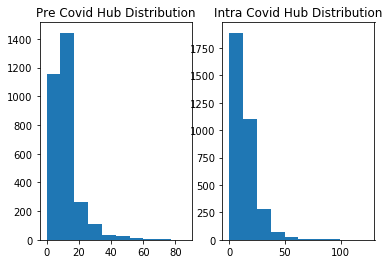

In [60]:
plt.subplot(121)

plt.hist(pre_num_hub)
plt.title("Pre Covid Hub Distribution")

plt.subplot(122)

plt.hist(intra_num_hub)
plt.title("Intra Covid Hub Distribution")

plt.show()

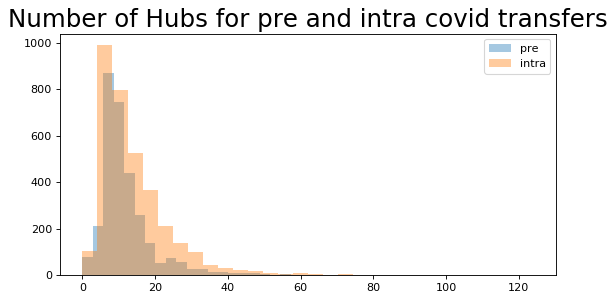

In [61]:
plt.figure(figsize=(8,4), dpi= 80)

plt.hist(pre_num_hub, alpha=0.4, label= 'pre', bins = 30)
plt.hist(intra_num_hub, alpha=0.4, label= 'intra', bins = 30)

plt.title('Number of Hubs for pre and intra covid transfers', fontsize=22)
plt.legend()
plt.show()

# Summary Table

In [62]:
def summary_list(covid_outcomes):
    result = {}
    
    stat = StatisMethod("","","","")
    
    patient_num = len(covid_outcomes)
    result['Patient_Number'] = patient_num
    
    visited_sites = []
    for index, row in covid_outcomes.iterrows():
        for i in range(len(row.pimd_path)):
            if row.pimd_path[i][0] not in visited_sites:
                visited_sites.append(row.pimd_path[i][0])
    site_num = len(visited_sites)
    result['Site_Number'] = site_num
    
    ethnicity = {}
    for index, row in covid_outcomes.iterrows():
        ethnicity[row.ETHNICITY_CONCEPT_ID] = ethnicity.get(row.ETHNICITY_CONCEPT_ID, 0) + 1
    result['Ethnicity'] = ethnicity
    
    age = []
    for index, row in covid_outcomes.iterrows():
        age.append(row.Age)
    
    age_stat = {}
    mean_age = np.mean(age)
    median_age = stat.f_median([age])[0]
    max_age = max(age)
    min_age = min(age)
    first_age = stat.f_first([age])[0]
    third_age = stat.f_third([age])[0]
    conf95_age = stat.conf95(age)
    age_stat['conf95'] = conf95_age
    age_stat['mean']=mean_age
    age_stat['median']=median_age
    age_stat['max']=max_age
    age_stat['min']=min_age
    age_stat['1st']=first_age
    age_stat['3rd']=third_age
    
    result['Age'] = age_stat
    
    los = []
    for index, row in covid_outcomes.iterrows():
        los.append(row.pimd_los)
    
    los_stat = {}
    mean_los = np.mean(los)
    median_los = stat.f_median([los])[0]
    max_los = max(los)
    min_los = min(los)
    first_los = stat.f_first([los])[0]
    third_los = stat.f_third([los])[0]
    conf95_los = stat.conf95(los)
    los_stat['conf95'] = conf95_los
    los_stat['mean']=mean_los
    los_stat['median']=median_los
    los_stat['max']=max_los
    los_stat['min']=min_los
    los_stat['1st']=first_los
    los_stat['3rd']=third_los
    
    result['LOS'] = los_stat
    
    # Gender
    gender = {}
    for index, row in covid_outcomes.iterrows():
        gender[row.GENDER_CONCEPT_ID] = gender.get(row.GENDER_CONCEPT_ID, 0) + 1
    result['Gender'] = gender
    
    race = {}
    for index, row in covid_outcomes.iterrows():
        race[row.RACE_CONCEPT_ID] = race.get(row.RACE_CONCEPT_ID, 0) + 1
    result['Race'] = race
    
    # ISS
    iss = []
    for index, row in covid_outcomes.iterrows():
        if int(row.pimd_iss) == -1:
            continue
        iss.append(float(row.pimd_iss))
    
    iss_stat = {}
    mean_iss = np.mean(iss)
    median_iss = stat.f_median([iss])[0]
    max_iss = max(iss)
    min_iss = min(iss)
    first_iss = stat.f_first([iss])[0]
    third_iss = stat.f_third([iss])[0]
    conf95_iss = stat.conf95(iss)
    iss_stat['conf95'] = conf95_iss
    iss_stat['mean']=mean_iss
    iss_stat['median']=median_iss
    iss_stat['max']=max_iss
    iss_stat['min']=min_iss
    iss_stat['1st']=first_iss
    iss_stat['3rd']=third_iss

    result['ISS'] = iss_stat
    
    #path len
    path_len = []
    for index, row in covid_outcomes.iterrows():
        path_len.append(row.path_len)
    
    path_len_stat = {}
    mean_path_len = np.mean(path_len)
    median_path_len = stat.f_median([path_len])[0]
    max_path_len = max(path_len)
    min_path_len = min(path_len)
    first_path_len = stat.f_first([path_len])[0]
    third_path_len = stat.f_third([path_len])[0]
    conf95_path_len = stat.conf95(path_len)
    path_len_stat['conf95'] = conf95_path_len
    path_len_stat['mean']=mean_path_len
    path_len_stat['median']=median_path_len
    path_len_stat['max']=max_path_len
    path_len_stat['min']=min_path_len
    path_len_stat['1st']=first_path_len
    path_len_stat['3rd']=third_path_len

    result['Path_Length'] = path_len_stat
    
    # discharge to 
    Discharge_to = {}
    for index, row in covid_outcomes.iterrows():
        Discharge_to[row.CONCEPT_NAME] = Discharge_to.get(row.CONCEPT_NAME, 0) + 1
    result['Dischargeto'] = Discharge_to
    
    # number of diagnosis
    num_diag = []
    for index, row in covid_outcomes.iterrows():
        num_diag.append(row.diagnose)
    
    nDiagnose_stat = {}
    mean_nDiagnose = np.mean(num_diag)
    median_nDiagnose = stat.f_median([num_diag])[0]
    max_nDiagnose = max(num_diag)
    min_nDiagnose = min(num_diag)
    first_nDiagnose = stat.f_first([num_diag])[0]
    third_nDiagnose = stat.f_third([num_diag])[0]
    conf95_nDiagnose = stat.conf95(num_diag)
    nDiagnose_stat['conf95'] = conf95_nDiagnose
    nDiagnose_stat['mean']=mean_nDiagnose
    nDiagnose_stat['median']=median_nDiagnose
    nDiagnose_stat['max']=max_nDiagnose
    nDiagnose_stat['min']=min_nDiagnose
    nDiagnose_stat['1st']=first_nDiagnose
    nDiagnose_stat['3rd']=third_nDiagnose

    result['Diagnose_num'] = nDiagnose_stat
    
    return result


In [63]:
pre_summary = summary_list(pre_covid_outcomes_s)
pre_summary

{'Patient_Number': 3050,
 'Site_Number': 77,
 'Ethnicity': {38003564: 2823, 38003563: 144, 0: 83},
 'Age': {'conf95': [51.368335094415485, 52.96150097115829],
  'mean': 52.164918032786886,
  'median': 53.0,
  'max': 104,
  'min': 15,
  '1st': 31.0,
  '3rd': 71.0},
 'LOS': {'conf95': [153.0829480267825, 167.3643306617421],
  'mean': 160.2236393442623,
  'median': 100.6,
  'max': 2487.9,
  'min': 0.0,
  '1st': 43.925,
  '3rd': 193.25000000000003},
 'Gender': {8507: 2007, 8532: 1041, 0: 2},
 'Race': {8527: 2431, 0: 172, 38003598: 426, 8515: 21},
 'ISS': {'conf95': [21.93131190106518, 22.86882024297182],
  'mean': 22.4000660720185,
  'median': 18.0,
  'max': 75.0,
  'min': 3.0,
  '1st': 13.0,
  '3rd': 27.0},
 'Path_Length': {'conf95': [18.686613305785233, 19.69371456306723],
  'mean': 19.19016393442623,
  'median': 15.0,
  'max': 162,
  'min': 3,
  '1st': 11.0,
  '3rd': 23.0},
 'Dischargeto': {'Home': 1830,
  'EXPIRED': 170,
  'Skilled Nursing Facility': 439,
  'Inpatient Long-term Care': 

In [64]:
intra_summary = summary_list(intra_covid_outcomes_s)
intra_summary

{'Patient_Number': 3393,
 'Site_Number': 96,
 'Ethnicity': {38003564: 3151, 38003563: 129, 0: 113},
 'Age': {'conf95': [51.11761639080286, 52.57115460831297],
  'mean': 51.844385499557916,
  'median': 52,
  'max': 104,
  'min': 15,
  '1st': 32.0,
  '3rd': 69.0},
 'LOS': {'conf95': [156.3731554785577, 169.33813246721297],
  'mean': 162.85564397288533,
  'median': 98.6,
  'max': 2759.2,
  'min': 0.6,
  '1st': 43.8,
  '3rd': 205.9},
 'Gender': {8507: 2269, 8532: 1124},
 'Race': {8527: 2697, 38003598: 457, 0: 209, 8515: 26, 8657: 4},
 'ISS': {'conf95': [22.97439596492917, 23.92509398406573],
  'mean': 23.44974497449745,
  'median': 19.0,
  'max': 75.0,
  'min': 9.0,
  '1st': 14.0,
  '3rd': 27.0},
 'Path_Length': {'conf95': [19.42432839863734, 20.339892055238284],
  'mean': 19.88211022693781,
  'median': 16,
  'max': 148,
  'min': 3,
  '1st': 11.0,
  '3rd': 24.0},
 'Dischargeto': {'Skilled Nursing Facility': 396,
  'Home': 2115,
  'Comprehensive Inpatient Rehabilitation Facility': 410,
  'I

In [65]:
# for key in pre_summary:
#     print("\""+ key+ "\""+",", end = "")

In [66]:
Sum_Data = {"pre_summary": pre_summary, "intra_summary":intra_summary}
sum_idx = ["Patient_Number","Site_Number","Ethnicity","Age","LOS","Gender","ISS","Path_Length","Dischargeto"]
Summary_table = pd.DataFrame(Sum_Data, index = sum_idx)
Summary_table

,pre_summary,intra_summary
Patient_Number,3050,3393
Site_Number,77,96
Ethnicity,"{38003564: 2823, 38003563: 144, 0: 83}","{38003564: 3151, 38003563: 129, 0: 113}"
Age,"{'conf95': [51.368335094415485, 52.96150097115...","{'conf95': [51.11761639080286, 52.571154608312..."
LOS,"{'conf95': [153.0829480267825, 167.36433066174...","{'conf95': [156.3731554785577, 169.33813246721..."
Gender,"{8507: 2007, 8532: 1041, 0: 2}","{8507: 2269, 8532: 1124}"
ISS,"{'conf95': [21.93131190106518, 22.868820242971...","{'conf95': [22.97439596492917, 23.925093984065..."
Path_Length,"{'conf95': [18.686613305785233, 19.69371456306...","{'conf95': [19.42432839863734, 20.339892055238..."
Dischargeto,"{'Home': 1830, 'EXPIRED': 170, 'Skilled Nursin...","{'Skilled Nursing Facility': 396, 'Home': 2115..."


# Generate network files

In [67]:
overall_sites = []
for index, row in pre_covid_outcomes_s.iterrows():
    for i in range(len(row.pimd_path)):
        if row.pimd_path[i] not in overall_sites:
            overall_sites.append(row.pimd_path[i])
            
for index, row in intra_covid_outcomes_s.iterrows():
    for i in range(len(row.pimd_path)):
        if row.pimd_path[i] not in overall_sites:
            overall_sites.append(row.pimd_path[i])
            

In [68]:
col = ["node_id","care_site_id", "node_name"]
idx = [i for i in range(len(overall_sites))]
node_file = pd.DataFrame(0, index = idx, columns = col) 

In [69]:
node_id = 0
for i in range(len(overall_sites)):
    node_file.iloc[i,0] = node_id
    node_id += 1
    node_file.iloc[i,1] = overall_sites[i][0]
    node_file.iloc[i,2] = overall_sites[i][1]

node_file

,node_id,care_site_id,node_name
0,0,1731232,VUH EMERGENCY
1,1,3121012,VUH 10N TRAUMA
2,2,4361014,VUH 6N NEUROSCIENCE
3,3,1371006,VUH MAIN OR
4,4,2991011,ZZZ-VUH10SORTHOTRAUMA
...,...,...,...
110,110,641010,HOLTER MCE 5
111,111,11921000,MAMMOGRAPHY OHO
112,112,631005,PFT LAB TVC B
113,113,16321004,WALK IN CLINIC X-RAY MELROSE


In [70]:
# node_file.to_csv("node_file.csv")

In [71]:
nah_list = []
out_range_list = []
for do in outcomes.itertuples():
    try:
        arrive_time = datetime.strptime(do[2] + " " + do[3], "%m/%d/%Y %H:%M")
        leave_time = datetime.strptime(do[6] + " " + do[7], "%m/%d/%Y %H:%M")
    except:
        nah_list.append(do[0])
        continue
    else:
        if arrive_time < pd.to_datetime('2020-03-01'):
            out_range_list.append(do[0])
        elif leave_time >= pd.to_datetime('2021-03-02'):
            out_range_list.append(do[0])

#     print('na',len(nah_list))
#     print('out_range',len(out_range_list))
outcomes_intra = outcomes.copy()    
outcomes_intra.drop(index = nah_list, inplace=True)
outcomes_intra.drop(index = out_range_list, inplace=True)
outcomes_intra.reset_index(drop=True)

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,ED_HOSP_ARRIVAL_TIME,ED_DISCHARGE_DATE,ED_DISCHARGE_TIME,HOSPITAL_DISCHARGE_DATE,HOSPITAL_DISCHARGE_TIME,LOCAL_ISS,ICD_10_PRIMARY_EXTERNAL_CAUSE_CODE,TRANSPORT_MODE,ICD_10_HOSPITAL_PROCEDURES,ICD_10_INJURY_DIAGNOSES,AIS_SEVERITY
0,190614327,1/1/2021,13:37,1/1/2021,23:27,1/6/2021,12:48,26.0,W06.XXXA,1,"BW25ZZZ, BR29ZZZ, BR27ZZZ, BW28ZZZ, BN25ZZZ, B...","S06.5X9A, S06.359A, S06.1X9A, S06.6X9A, S22.43...","4, 3, 3, 2, 3, 1, 1, 1, 1"
1,189484330,1/1/2021,19:36,1/1/2021,22:10,1/6/2021,9:04,9.0,W32.0XXA,2,"BQ2SZZZ, 0QS936Z, 30233N1 ...",S72.352B ...,3
2,9450437,1/1/2021,15:50,1/1/2021,18:29,1/7/2021,8:22,9.0,W01.0XXA,1,"BW28ZZZ, BR20ZZZ, BW25YZZ, BR27YZZ, BR29YZZ, 3...",S72.142A ...,3
3,9010465,1/1/2021,22:10,1/2/2021,3:56,1/4/2021,11:59,9.0,V43.62XA,1,"BW25YZZ, BR29ZZZ, BR27ZZZ, BW28ZZZ, BR20ZZZ ...","S22.43XA, S22.22XA ...","3, 2"
4,192114320,1/1/2021,17:14,1/1/2021,17:44,1/8/2021,9:33,34.0,V49.50XA,2,"30233N1, BW28ZZZ, BR20ZZZ, BW25YZZ, BR29YZZ, B...","S36.116A, S27.0XXA, S22.028A, S22.038A, S22.04...","4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,175934315,9/9/2020,22:33,9/10/2020,1:20,9/16/2020,12:56,26.0,V86.56XA,2,"BW25YZZ, BW24YZZ, 0W9B30Z, 00HU33Z ...","S36.032A, S22.42XA, S27.1XXA, S27.321A, S27.33...","4, 3, 3, 2, 3, 1"
3337,7260211,9/9/2020,8:10,9/9/2020,12:39,9/11/2020,13:27,10.0,W20.8XXA,1,"BW28ZZZ, BR20ZZZ, BW25YZZ, BR29YZZ, BR27YZZ, 0...","S20.211A, S27.69XA, S27.892A, S27.1XXA, S01.51...","1, 1, 2, 3, 1, 3"
3338,11091642,9/9/2020,0:03,9/9/2020,3:07,9/14/2020,14:57,17.0,X95.9XXA,1,"0PSG04Z, 0QS5XZZ, BP2UZZZ, BQ2SZZZ, BQ2RZZZ, B...","S42.422B, S32.422A, S02.2XXA, S02.40DA, S22.42...","2, 2, 1, 2, 3, 2, 1"
3339,5847717,9/9/2020,16:05,9/9/2020,20:15,9/16/2020,12:45,17.0,W01.0XXA,1,"BW28ZZZ, BN25ZZZ, BR20ZZZ, B328YZZ, B325YZZ, B...","S14.153A, S00.81XA, S40.811A, S80.811A ...","4, 1, 1, 1"


In [72]:
 pd.merge(trauma_outcome, demo[['PERSON_ID','HOSPITAL_DISCHARGE_DATE','BIRTH_DATETIME','ETHNICITY_CONCEPT_ID','CONCEPT_NAME','RACE_CONCEPT_ID','GENDER_CONCEPT_ID']], left_on=['PERSON_ID','HOSPITAL_DISCHARGE_DATE'], right_on=['PERSON_ID','HOSPITAL_DISCHARGE_DATE'])

,PERSON_ID,ED_HOSP_ARRIVAL_DATE,HOSPITAL_DISCHARGE_DATE,pimd_path,path_len,pimd_iss,pimd_los,diagnose,BIRTH_DATETIME,ETHNICITY_CONCEPT_ID,CONCEPT_NAME,RACE_CONCEPT_ID,GENDER_CONCEPT_ID
0,8966376,2017-01-01,2017-01-05,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",8,50,96.4,13,1991-02-10 00:00:00.0000000,38003564,Home,8527,8507
1,7508586,2017-01-01,2017-01-04,"[(26391046, ED SPECIALTY ADULT), (27541043, 10...",11,22,80.1,8,1989-02-24 00:00:00.0000000,38003564,Home,38003598,8507
2,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22 00:00:00.0000000,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507
3,12522608,2017-01-01,2017-01-06,"[(26391046, ED SPECIALTY ADULT), (26391046, ED...",15,29,128.0,6,1991-11-22 00:00:00.0000000,38003564,Home,8527,8507
4,10201634,2017-01-01,2017-01-12,"[(26391046, ED SPECIALTY ADULT), (27701051, MA...",13,12,252.2,6,1993-11-14 00:00:00.0000000,38003564,Home,38003598,8507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13409,175934315,2020-09-09,2020-09-16,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",28,34,158.4,7,1986-08-10 00:00:00.0000000,38003564,Home,8527,8507
13410,7260211,2020-09-09,2020-09-11,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",11,22,53.3,6,1959-01-15 00:00:00.0000000,38003564,Home,8527,8507
13411,11091642,2020-09-09,2020-09-14,"[(1731232, VUH EMERGENCY), (1731232, VUH EMERG...",18,17,134.9,7,1964-03-09 00:00:00.0000000,38003564,Prison / Correctional Facility,38003598,8507
13412,5847717,2020-09-09,2020-09-16,"[(3921007, WALK IN CLINIC X-RAY COOL SPRINGS),...",24,18,164.7,4,1958-10-04 00:00:00.0000000,38003564,Comprehensive Inpatient Rehabilitation Facility,8527,8507


In [73]:
pre_file = pd.merge(pre_out, node_file[["node_id","care_site_id"]],left_on=["Location1"], right_on=["care_site_id"])
pre_file.rename(columns={'node_id':'Source', 'care_site_id': 'care_site_id_a'},inplace=True) 
pre_file = pd.merge(pre_file, node_file[["node_id","care_site_id"]],left_on=["Location2"], right_on=["care_site_id"])
pre_file.rename(columns={'node_id':'Target'},inplace=True) 
pre_file = pre_file[['Source', 'Target','Weight']]
pre_file['Type'] =  ['Directed' for i in range(len(pre_file))]
pre_file

,Source,Target,Weight,Type
0,1,0,1758,Directed
1,3,0,2,Directed
2,4,0,2,Directed
3,6,0,39,Directed
4,15,0,5,Directed
...,...,...,...,...
716,40,64,1,Directed
717,40,46,4,Directed
718,43,46,4,Directed
719,40,51,4,Directed


In [74]:
intra_file = pd.merge(intra_out, node_file[["node_id","care_site_id"]],left_on=["Location1"], right_on=["care_site_id"])
intra_file.rename(columns={'node_id':'Source', 'care_site_id': 'care_site_id_a'},inplace=True) 
intra_file = pd.merge(intra_file, node_file[["node_id","care_site_id"]],left_on=["Location2"], right_on=["care_site_id"])
intra_file.rename(columns={'node_id':'Target'},inplace=True) 
intra_file = intra_file[['Source', 'Target','Weight']]
intra_file['Type'] = ['Directed' for i in range(len(intra_file))]
intra_file

,Source,Target,Weight,Type
0,1,0,1653,Directed
1,25,0,3,Directed
2,5,0,36,Directed
3,21,0,1,Directed
4,77,0,92,Directed
...,...,...,...,...
772,108,107,1,Directed
773,108,109,1,Directed
774,93,94,2,Directed
775,81,89,2,Directed


In [75]:
# intra_file.to_csv("intra_edge_file.csv")

In [76]:
# pre_file.to_csv("pre_edge_file.csv")

In [77]:
pre_wi_outdegree = pre_out.groupby('Location1')['Weight'].sum()
pre_wi_indegree = pre_out.groupby('Location2')['Weight'].sum()
intra_wi_outdegree = intra_out.groupby('Location1')['Weight'].sum()
intra_wi_indegree = intra_out.groupby('Location2')['Weight'].sum()

In [78]:
pre_wi_outdegree

Location1
81015         1
111008      326
111009        6
221005       32
421012       48
           ... 
11161000      2
16781000      2
20471026      4
21861031      4
21911021     20
Name: Weight, Length: 77, dtype: int64

# edge difference

In [80]:
source_target = []
difference_edge = []

for index, row in pre_file.iterrows():
    pre_weight = row.Weight
    source_target.append([row.Source, row.Target])
    
    temp = intra_file[(intra_file['Source']==row.Source)&(intra_file['Target']==row.Target)]
    
    if len(temp) == 0:
        color = 2
        difference_edge.append([abs(pre_weight), color])
    else:
        for idx,r in temp.iterrows():
            intra_weight = r.Weight
            break
        d = pre_weight-intra_weight
        if d >= 0:
            color = 0
        if d < 0:
            color = 1
        difference_edge.append([abs(d), color])

for index, row in intra_file.iterrows():
    if [row.Source, row.Target] in source_target:
        continue
    
    intra_weight = row.Weight
    source_target.append([row.Source, row.Target])
    difference_edge.append([abs(intra_weight), 3])
    
so = []
ta = []
we = []
co = []
for _ in source_target:
    so.append(_[0])
    ta.append(_[1])
    
for _ in difference_edge:
    we.append(_[0])
    co.append(_[1])

col = ["Source","Target", "Weight difference","Type","Weight color"]
idx = [i for i in range(len(source_target))]
edge_difference_file = pd.DataFrame(0, index = idx, columns = col) 

edge_difference_file['Source'] = so
edge_difference_file['Target'] = ta
edge_difference_file['Weight difference'] = we
edge_difference_file['Weight color'] = co
edge_difference_file['Type'] = ['Directed' for i in range(len(source_target))]


edge_difference_file
edge_difference_file.to_csv("edge_difference_fileV2.csv")

# node difference

In [ ]:
difference_indegree = []

for index, row in node_file.iterrows():
    care_site = row.care_site_id
    
    temp_pre = pre_metrics[pre_metrics["CARE_SITE_ID"]==care_site]
    for idx, r in temp_pre.iterrows():
        pre_num = r.In_Degree
    
    temp_intra = intra_metrics[intra_metrics["CARE_SITE_ID"]==care_site]
    for idx, r in temp_intra.iterrows():
        intra_num = r.In_Degree

    if len(temp_pre)!=0 and len(temp_intra)==0:
        difference_indegree.append([abs(pre_num),2])
    if len(temp_pre)==0 and len(temp_intra)!=0:
        difference_indegree.append([abs(intra_num),3])
    if len(temp_pre)!=0 and len(temp_intra)!=0:
        d = pre_num-intra_num
        if d>=0:
            difference_indegree.append([abs(d),0])
        else:
            difference_indegree.append([abs(d),1])
            
            

difference_outdegree = []

for index, row in node_file.iterrows():
    care_site = row.care_site_id
    
    temp_pre = pre_metrics[pre_metrics["CARE_SITE_ID"]==care_site]
    for idx, r in temp_pre.iterrows():
        pre_num = r.Out_Degree
    
    temp_intra = intra_metrics[intra_metrics["CARE_SITE_ID"]==care_site]
    for idx, r in temp_intra.iterrows():
        intra_num = r.Out_Degree

    if len(temp_pre)!=0 and len(temp_intra)==0:
        difference_outdegree.append([abs(pre_num),2])
    if len(temp_pre)==0 and len(temp_intra)!=0:
        difference_outdegree.append([abs(intra_num),3])
    if len(temp_pre)!=0 and len(temp_intra)!=0:
        d = pre_num-intra_num
        if d>=0:
            difference_outdegree.append([abs(d),0])
        else:
            difference_outdegree.append([abs(d),1])

idd = []
idc = []
for _ in difference_indegree:
    idd.append(_[0])
    idc.append(_[1])
    
odd = []
odc = []
for _ in difference_outdegree:
    odd.append(_[0])
    odc.append(_[1])
    
node_file["In-degree difference"] = idd
node_file["In-degree difference color"] = idc 
node_file["out-degree difference"] = odd
node_file["out-degree difference color"] = odc


In [ ]:
node_file.to_csv("node_difference_fileV1.csv")

## Patient level regression model

In [ ]:
pre_covid_outcomes_s.columns

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import scipy as sp

In [ ]:
pre_covid_outcomes_reg = pre_covid_outcomes_s[[ 'diagnose', 'GENDER_CONCEPT_ID', 'Age', 'pimd_iss', 'pimd_los']]
pre_covid_outcomes_reg = pre_covid_outcomes_reg[pre_covid_outcomes_reg['GENDER_CONCEPT_ID']!=0]
pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
est2_s = est.fit()
print(est2_s.summary())

In [ ]:
intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 'pimd_iss', 'pimd_los']]
intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
est2_s = est.fit()
print(est2_s.summary())

In [ ]:
pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs', 'pimd_los']]
pre_covid_outcomes_reg = pre_covid_outcomes_reg[pre_covid_outcomes_reg['GENDER_CONCEPT_ID']!=0]
pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
est2_f = est.fit()
print(est2_f.summary())

In [ ]:
intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs', 'pimd_los']]
intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
est2_f = est.fit()
print(est2_f.summary())

In [ ]:
print(np.median(intra_covid_outcomes_s['pimd_los']))
print(np.median(pre_covid_outcomes_s['pimd_los']))

## Patient level Correlation test

In [ ]:
from scipy import stats

intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs', 'pimd_los']]
intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

intra_covid_outcomes_pearson_r = pd.DataFrame(0,index=range(20),columns=range(20))
intra_covid_outcomes_pearson_p = pd.DataFrame(0,index=range(20),columns=range(20))
intra_covid_outcomes_spearman_r = pd.DataFrame(0,index=range(20),columns=range(20))
intra_covid_outcomes_spearman_p = pd.DataFrame(0,index=range(20),columns=range(20))
intra_covid_outcomes_kendalltau_r = pd.DataFrame(0,index=range(20),columns=range(20))
intra_covid_outcomes_kendalltau_p = pd.DataFrame(0,index=range(20),columns=range(20))
for i in range(20):
    for j in range(20):
        r,p = stats.pearsonr(intra_covid_outcomes_reg.iloc[:,i], intra_covid_outcomes_reg.iloc[:,j])
        intra_covid_outcomes_pearson_r.iloc[i,j] = r
        intra_covid_outcomes_pearson_p.iloc[i,j] = p
        #print('Pearson r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)
        r,p = stats.spearmanr(intra_covid_outcomes_reg.iloc[:,i], intra_covid_outcomes_reg.iloc[:,j])
        intra_covid_outcomes_spearman_r.iloc[i,j] = r
        intra_covid_outcomes_spearman_p.iloc[i,j] = p
        #print('Spearman r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)
        r,p = stats.kendalltau(intra_covid_outcomes_reg.iloc[:,i], intra_covid_outcomes_reg.iloc[:,j])
        intra_covid_outcomes_kendalltau_r.iloc[i,j] = r
        intra_covid_outcomes_kendalltau_p.iloc[i,j] = p
        #print('Kendalltau r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)

In [ ]:
pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs', 'pimd_los']]
pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')


pre_covid_outcomes_pearson_r = pd.DataFrame(0,index=range(20),columns=range(20))
pre_covid_outcomes_pearson_p = pd.DataFrame(0,index=range(20),columns=range(20))
pre_covid_outcomes_spearman_r = pd.DataFrame(0,index=range(20),columns=range(20))
pre_covid_outcomes_spearman_p = pd.DataFrame(0,index=range(20),columns=range(20))
pre_covid_outcomes_kendalltau_r = pd.DataFrame(0,index=range(20),columns=range(20))
pre_covid_outcomes_kendalltau_p = pd.DataFrame(0,index=range(20),columns=range(20))
for i in range(20):
    for j in range(20):
        r,p = stats.pearsonr(pre_covid_outcomes_reg.iloc[:,i], pre_covid_outcomes_reg.iloc[:,j])
        pre_covid_outcomes_pearson_r.iloc[i,j] = r
        pre_covid_outcomes_pearson_p.iloc[i,j] = p
        #print('Pearson r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)
        r,p = stats.spearmanr(pre_covid_outcomes_reg.iloc[:,i], pre_covid_outcomes_reg.iloc[:,j])
        pre_covid_outcomes_spearman_r.iloc[i,j] = r
        pre_covid_outcomes_spearman_p.iloc[i,j] = p
        #print('Spearman r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)
        r,p = stats.kendalltau(pre_covid_outcomes_reg.iloc[:,i], pre_covid_outcomes_reg.iloc[:,j])
        pre_covid_outcomes_kendalltau_r.iloc[i,j] = r
        pre_covid_outcomes_kendalltau_p.iloc[i,j] = p
        #print('Kendalltau r = %6.3f，p-value = %6.3f'%(r,p),p<=0.01)

In [ ]:
alpha = 0.05
# m = 9730
# alpha_corrected = alpha / (3*m)
print(sum(((pre_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1)==2))
print(sum(((pre_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1)==1))
print(sum(((pre_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1)==0))

In [ ]:
alpha = 0.05

PP = ((pre_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1)==2
NP = ((pre_covid_outcomes_spearman_p.iloc[:-1,-1]>=alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1)==2
PN = ((pre_covid_outcomes_spearman_p.iloc[:-1,-1]<alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]>=alpha)*1)==2
NN = ((pre_covid_outcomes_spearman_p.iloc[:-1,-1]>=alpha)*1 + (intra_covid_outcomes_spearman_p.iloc[:-1,-1]>=alpha)*1)==2

L11 = ((pre_covid_outcomes_spearman_r.iloc[:-1,-1][PP]>0)*1 + (intra_covid_outcomes_spearman_r.iloc[:-1,-1][PP]>0)*1)==2
L00 = ((pre_covid_outcomes_spearman_r.iloc[:-1,-1][PP]<0)*1 + (intra_covid_outcomes_spearman_r.iloc[:-1,-1][PP]<0)*1)==2
L01 = ((pre_covid_outcomes_spearman_r.iloc[:-1,-1][PP]<0)*1 + (intra_covid_outcomes_spearman_r.iloc[:-1,-1][PP]>0)*1)==2
L10 = ((pre_covid_outcomes_spearman_r.iloc[:-1,-1][PP]>0)*1 + (intra_covid_outcomes_spearman_r.iloc[:-1,-1][PP]<0)*1)==2
LN0 = intra_covid_outcomes_spearman_r.iloc[:-1,-1][NP]<0
LN1 = intra_covid_outcomes_spearman_r.iloc[:-1,-1][NP]>0
L0N = pre_covid_outcomes_spearman_r.iloc[:-1,-1][PN]<0
L1N = pre_covid_outcomes_spearman_r.iloc[:-1,-1][PN]>0
LNN = pre_covid_outcomes_spearman_p.iloc[:-1,-1][NN]<1

L11 = np.array(L11[L11].index)
L00 = np.array(L00[L00].index)
L01 = np.array(L01[L01].index)
L10 = np.array(L10[L10].index)
LN0 = np.array(LN0[LN0].index)
LN1 = np.array(LN1[LN1].index)
L0N = np.array(L0N[L0N].index)
L1N = np.array(L1N[L1N].index)
LNN = np.array(LNN[LNN].index)

trauma_features = np.array(['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs', 'pimd_los'])
print('++',trauma_features[L11].shape[0],trauma_features[L11])
print('--',trauma_features[L00].shape[0],trauma_features[L00])
print('-+',trauma_features[L01].shape[0],trauma_features[L01])
print('+-',trauma_features[L10].shape[0],trauma_features[L10])
print('N-',trauma_features[LN0].shape[0],trauma_features[LN0])
print('N+',trauma_features[LN1].shape[0],trauma_features[LN1])
print('-N',trauma_features[L0N].shape[0],trauma_features[L0N])
print('+N',trauma_features[L1N].shape[0],trauma_features[L1N])
print('NN',trauma_features[LNN].shape[0],trauma_features[LNN])

## Patient level Likelihood Ratio Test

In [ ]:
intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'pimd_los']]
intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
est2_f = est.fit()

intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'pimd_los']]
intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
est2_s = est.fit()



df_full = est2_f.df_resid 
df_restr = est2_s.df_resid 
lrdf = (df_restr - df_full)
lrstat = -2*(est2_s.llf - est2_f.llf)
lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
print(lr_pvalue)

In [ ]:
pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'pimd_los']]
pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
est2_f = est.fit()

pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'pimd_los']]
pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

X = sm.add_constant(scaled_data)

est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
est2_s = est.fit()



df_full = est2_f.df_resid 
df_restr = est2_s.df_resid 
lrdf = (df_restr - df_full)
lrstat = -2*(est2_s.llf - est2_f.llf)
lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
print(lr_pvalue)

In [ ]:
metrice_list = ['indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs']

print('pre-covid')
for i in range(len(metrice_list)):
    pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'pimd_los']]
    pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
    est2_s = est.fit()
    
    pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', metrice_list[i], 'pimd_los']]
    pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
    est2_f = est.fit()

    df_full = est2_f.df_resid 
    df_restr = est2_s.df_resid 
    lrdf = (df_restr - df_full)
    lrstat = -2*(est2_s.llf - est2_f.llf)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    
    print(metrice_list[i],lr_pvalue<0.05)
    
print('intra-covid')
for i in range(len(metrice_list)):
    intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', 'pimd_los']]
    intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
    est2_s = est.fit()
    
    intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', metrice_list[i], 'pimd_los']]
    intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
    est2_f = est.fit()

    df_full = est2_f.df_resid 
    df_restr = est2_s.df_resid 
    lrdf = (df_restr - df_full)
    lrstat = -2*(est2_s.llf - est2_f.llf)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    
    print(metrice_list[i],lr_pvalue<0.05)
    

In [ ]:
metrice_list = ['path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs']

print('pre-covid')
for i in range(len(metrice_list)):
    pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'pimd_los']]
    pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
    est2_s = est.fit()
    
    pre_covid_outcomes_reg = pre_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', metrice_list[i], 'pimd_los']]
    pre_covid_outcomes_reg = pre_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(pre_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(pre_covid_outcomes_reg.iloc[:,-1], X)
    est2_f = est.fit()

    df_full = est2_f.df_resid 
    df_restr = est2_s.df_resid 
    lrdf = (df_restr - df_full)
    lrstat = -2*(est2_s.llf - est2_f.llf)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    
    print(metrice_list[i],lr_pvalue<0.05)
    
print('intra-covid')
for i in range(len(metrice_list)):
    intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'pimd_los']]
    intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
    est2_s = est.fit()
    
    intra_covid_outcomes_reg = intra_covid_outcomes_s[['diagnose', 'GENDER_CONCEPT_ID', 'Age', 
       'pimd_iss', 'path_len', metrice_list[i], 'pimd_los']]
    intra_covid_outcomes_reg = intra_covid_outcomes_reg.astype('float')

    scaled_data = sp.stats.zscore(intra_covid_outcomes_reg.iloc[:,:-1])

    X = sm.add_constant(scaled_data)

    est = sm.OLS(intra_covid_outcomes_reg.iloc[:,-1], X)
    est2_f = est.fit()

    df_full = est2_f.df_resid 
    df_restr = est2_s.df_resid 
    lrdf = (df_restr - df_full)
    lrstat = -2*(est2_s.llf - est2_f.llf)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    
    print(metrice_list[i],lr_pvalue<0.05)



## Patient level Comparsion Test

In [ ]:
from scipy import stats

test_list = ['outdegree_third', 'indegree_max', 'outdegree_max', 'indegree_bs']
for i in range(len(test_list)):
    rv1 = pre_covid_outcomes_s[test_list[i]]
    rv2 = intra_covid_outcomes_s[test_list[i]]
    stat, p = stats.levene(rv1, rv2)
    print(test_list[i])
    print(stats.levene(rv1, rv2))
    var_t = p>=0.05
    print(stats.ttest_ind(rv1, rv2, equal_var=var_t))

In [ ]:
test_list = ['indegree_median', 'outdegree_median', 'outdegree_third', 'outdegree_max', 'indegree_average', 'outdegree_average']
for i in range(len(test_list)):
    rv1 = pre_covid_outcomes_s[test_list[i]]
    rv2 = intra_covid_outcomes_s[test_list[i]]
    stat, p = stats.levene(rv1, rv2)
    print(test_list[i])
    print(stats.levene(rv1, rv2))
    var_t = p>=0.05
    print(stats.ttest_ind(rv1, rv2, equal_var=var_t))

In [ ]:
test_list = ['path_len', 'indegree_average', 'outdegree_average', 'indegree_median',
       'outdegree_median', 'indegree_min', 'outdegree_min', 'indegree_first',
       'outdegree_first', 'indegree_third', 'outdegree_third', 'indegree_max',
       'outdegree_max', 'indegree_bs', 'outdegree_bs']
for i in range(len(test_list)):
    rv1 = pre_covid_outcomes_s[test_list[i]]
    rv2 = intra_covid_outcomes_s[test_list[i]]
    stat, p = stats.levene(rv1, rv2)
    print(test_list[i])
    print(stats.levene(rv1, rv2))
    var_t = p>=0.05
    print(stats.ttest_ind(rv1, rv2, equal_var=var_t))

In [ ]:
pre_metrics.sort_values('In_Degree',ascending=False)

In [ ]:
pre_metrics.sort_values('Out_Degree',ascending=False)

In [ ]:
intra_metrics.sort_values('Out_Degree',ascending=False)